# Delinquency Prediction Project
Optimized and structured notebook for data preprocessing, analysis, and classification.

## 1. Setup and Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE


## 2. Data Loading and Initial Inspection

In [14]:
df = pd.read_csv('Delinquency_prediction_dataset.csv')
df.head()


,Customer_ID,Age,Income,Credit_Score,Credit_Utilization,Missed_Payments,Delinquent_Account,Loan_Balance,Debt_to_Income_Ratio,Employment_Status,Account_Tenure,Credit_Card_Type,Location,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6
0,CUST0001,56,165580.0,398.0,0.390502,3,0,16310.0,0.317396,EMP,18,Student,Los Angeles,Late,Late,Missed,Late,Missed,Late
1,CUST0002,69,100999.0,493.0,0.312444,6,1,17401.0,0.196093,Self-employed,0,Standard,Phoenix,Missed,Missed,Late,Missed,On-time,On-time
2,CUST0003,46,188416.0,500.0,0.359930,0,0,13761.0,0.301655,Self-employed,1,Platinum,Chicago,Missed,Late,Late,On-time,Missed,Late
3,CUST0004,32,101672.0,413.0,0.371400,3,0,88778.0,0.264794,Unemployed,15,Platinum,Phoenix,Late,Missed,Late,Missed,Late,Late
4,CUST0005,60,38524.0,487.0,0.234716,2,0,13316.0,0.510583,Self-employed,11,Standard,Phoenix,Missed,On-time,Missed,Late,Late,Late


In [15]:
df.isnull().sum()

,0
Customer_ID,0
Age,0
Income,39
Credit_Score,2
Credit_Utilization,0
Missed_Payments,0
Delinquent_Account,0
Loan_Balance,29
Debt_to_Income_Ratio,0
Employment_Status,0


## 3. Data Cleaning and Imputation

In [16]:
df['Income'].fillna(df['Income'].median(), inplace=True)
df['Credit_Score'].fillna(df['Credit_Score'].mean(), inplace=True)
df['Loan_Balance'].fillna(df['Loan_Balance'].median(), inplace=True)


/tmp/ipython-input-917097585.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)
/tmp/ipython-input-917097585.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

## 4. Feature Engineering

In [17]:
month_map = {'On-time': 0, 'Late': 1, 'Missed': 2}
month_cols = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6']
for col in month_cols:
    df[col] = df[col].map(month_map)

df['Total_Monthly_Delinquency'] = df[month_cols].sum(axis=1)
df['Average_Monthly_Delinquency'] = df[month_cols].mean(axis=1)
df['Delinquency_Trend'] = df[month_cols].diff(axis=1).mean(axis=1)
df['High_Utilization_Flag'] = (df['Credit_Utilization'] > 0.8).astype(int)
df['Low_Credit_Score_Flag'] = (df['Credit_Score'] < 600).astype(int)
df['Tenure_Bucket'] = pd.cut(df['Account_Tenure'], bins=[-1, 3, 10, 20], labels=['New', 'Mid', 'Loyal'])

df.drop(columns=['Customer_ID'], inplace=True)


## 5. Correlation and Exploratory Data Analysis

/tmp/ipython-input-278003225.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_4_features.index, y=top_4_features.values, palette='viridis')


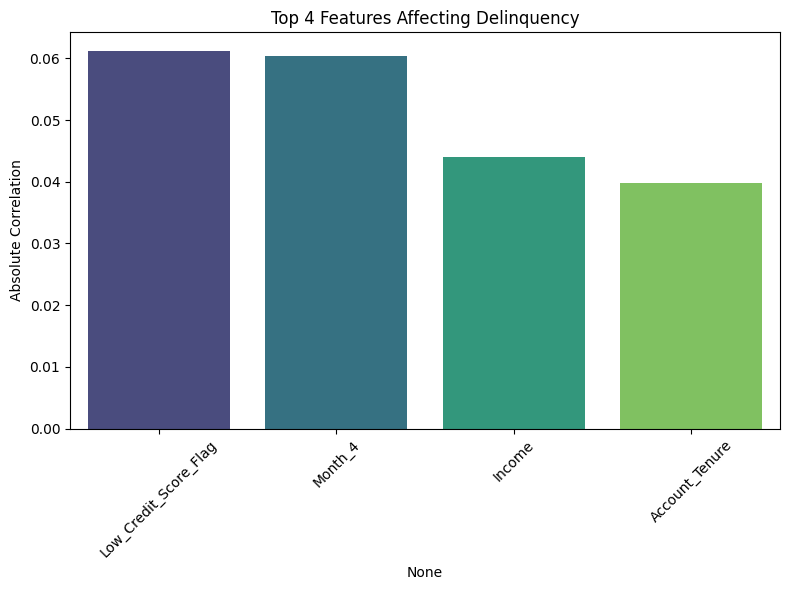

In [18]:
correlation = df.corr(numeric_only=True)['Delinquent_Account'].sort_values(ascending=False)
top_4_features = correlation.abs().sort_values(ascending=False).head(5).drop('Delinquent_Account')

plt.figure(figsize=(8, 6))
sns.barplot(x=top_4_features.index, y=top_4_features.values, palette='viridis')
plt.title('Top 4 Features Affecting Delinquency')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


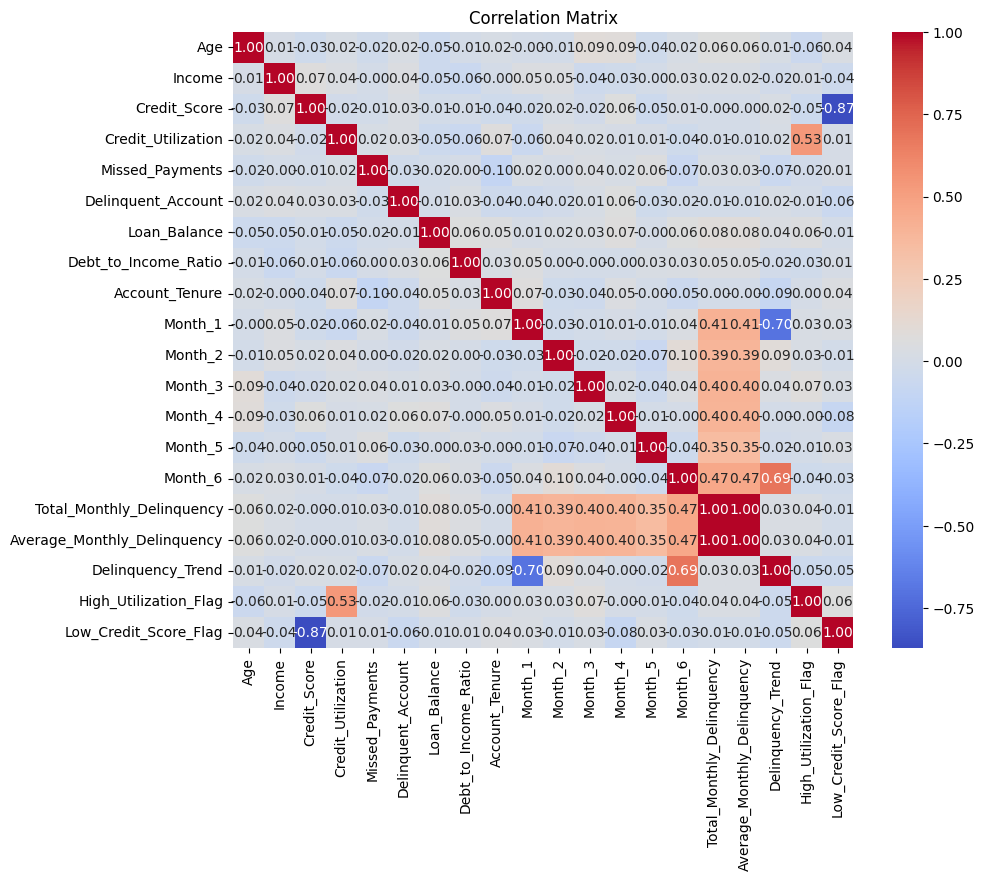

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


## 6. Data Preparation

In [20]:
df_encoded = pd.get_dummies(df, drop_first=True)
X = df_encoded.drop(columns=['Delinquent_Account'])
y = df_encoded['Delinquent_Account']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


## 7. Model Training and Evaluation

In [21]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.90        84
           1       0.00      0.00      0.00        16

    accuracy                           0.82       100
   macro avg       0.42      0.49      0.45       100
weighted avg       0.70      0.82      0.76       100

Confusion Matrix:
 [[82  2]
 [16  0]]
ROC AUC Score: 0.4252232142857143


## 8. ROC Curve Visualization

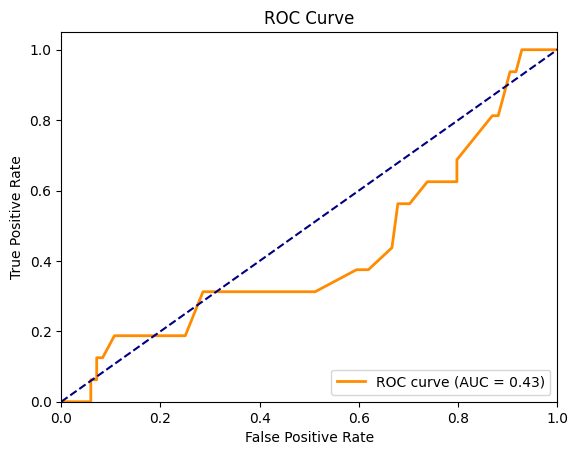

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


## 9. Logistic Regression Model (with Balanced Class Weights)

In [28]:
from sklearn.linear_model import LogisticRegression

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train logistic regression model
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train_bal, y_train_bal)

# Predict and evaluate
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Adjust classification threshold
threshold = 0.45
y_pred_thresh = (y_proba_log >= threshold).astype(int)

# Evaluate new predictions
print(f"Classification Report (threshold = {threshold}):\n")
print(classification_report(y_test, y_pred_thresh))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_log))


Classification Report (threshold = 0.45):

              precision    recall  f1-score   support

           0       0.80      0.54      0.64        84
           1       0.11      0.31      0.17        16

    accuracy                           0.50       100
   macro avg       0.46      0.42      0.40       100
weighted avg       0.69      0.50      0.57       100

Confusion Matrix:
 [[50 34]
 [12  4]]
ROC AUC Score: 0.4025297619047619
